# Исследование для интернет-магазина компьютерных игр "Стримчик"

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Данные до 2016 года. За 2016 год данные могут быть неполными.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр.

Столбцы

* `Name` — название игры
* `Platform` — платформа
* `Year_of_Release` — год выпуска
* `Genre` — жанр игры
* `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
* `EU_sales` — продажи в Европе (миллионы проданных копий)
* `JP_sales` — продажи в Японии (миллионы проданных копий)
* `Other_sales` — продажи в других странах (миллионы проданных копий)
* `Critic_Score` — оценка критиков (максимум 100)
* `User_Score` — оценка пользователей (максимум 10)
* `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

In [1]:
import pandas as pd
from scipy import stats as st
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv('/datasets/games.csv')

## Предварительный просмотр данных

In [3]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


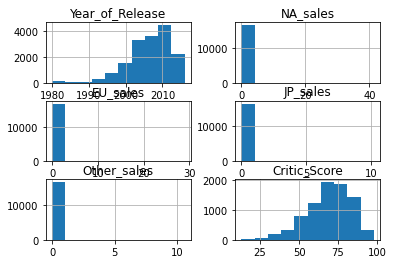

In [4]:
data.hist();

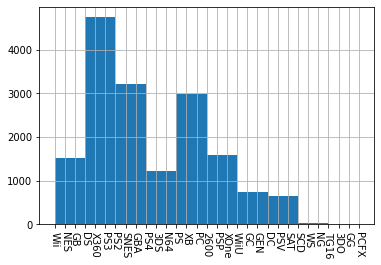

In [5]:
data['Platform'].hist();
plt.xticks(rotation = 270);

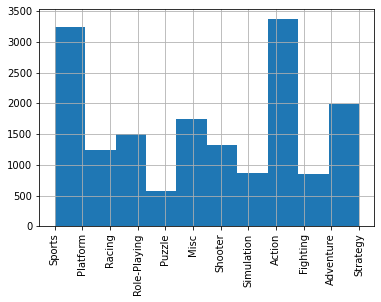

In [6]:
data['Genre'].hist();
plt.xticks(rotation = 90);

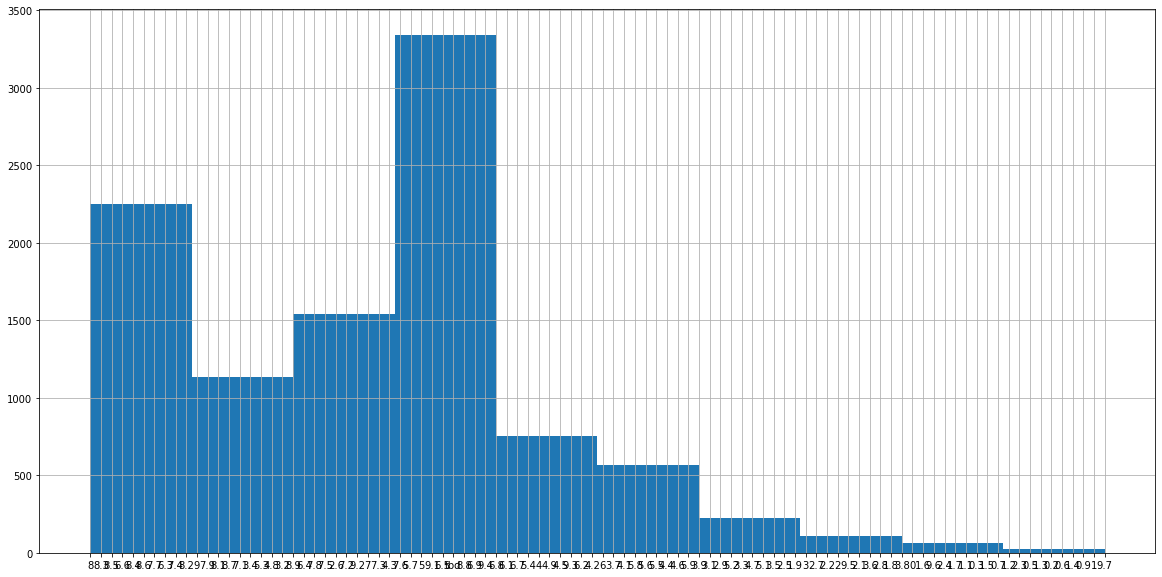

In [7]:
data['User_Score'].hist(figsize=(20, 10));

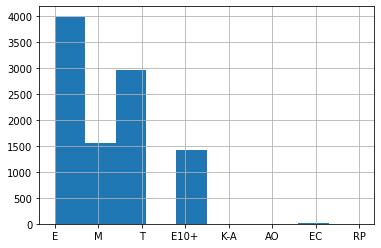

In [8]:
data['Rating'].hist();

In [9]:
data.duplicated().sum()

0

### Вывод 

Сразу же бросается в глаза - заглавные буквы в названии столбцов.

8 из 11 столбцов значимого количества пропусков не имеют. В 3 последних пропуски есть и это до половины данных.

У некоторых столбцов неправильные типы данных.

Предварительно гистограммы показывают наличие выбросов и аномалий. Разнообразие в категориальных данных. Некоторые данные не отобразились или некорректно. Одна из причин это неправильные типы данных.

Явных дубликатов нет.

## Предобработка данных 

Первым делом приводим столбцы к нижнему регистру для удобства работы и следуя стандартам.

In [10]:
columns_lower_name = data.columns.str.lower()
for i in range(len(data.columns)):
    data = data.rename(columns={data.columns[i]: columns_lower_name[i]})

In [11]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Вторая важная ступенька - это преобразование типов данных к корректным. Тут же работа с пропусками - потому что float и NaN. 

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Заменяем float в годах на int. Следует из названия столбца, что там должно быть целочисленное значение. Float там по техническим причинам из-за NaN.

In [13]:
data['year_of_release'] = data['year_of_release'].fillna(0)

In [14]:
data['year_of_release'] = data['year_of_release'].astype('int')

Удаляем строки с пропусками в жанре и имени - всего 2 строки где нет ни того, ни того. Без этого строки особо не интересны.

In [15]:
data = data.dropna(subset=['genre'])
data.reset_index(drop=True, inplace=True)

В столбце с оценками пользователей тип object из-за строкового значения tbd - подлежит оценке. Заменяем на NaN и приводим к типу float. Это все таки количественная переменная.

In [16]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = 'NaN'

In [17]:
data['user_score'] = data['user_score'].astype('float')

В 3 последних столбцах с оценками игры и рейтингом пропуски трогать не будем. Оценки могут быть как очень высокие, так и очень низкие. Рейтинг тоже угадать нельзя - была идея по жанрам попробовать добавить минимальный, но отбросил.

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16713 non-null  int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


Также проверил на неявные дубликаты. С помощью нижнего регистра и размера уникальных названий в названиях игр - размеры совпали. Жанры и рейтинги тоже не содержать неявных дубликатов.
Единсвтенное, что вызвало сомнения - делал проверку на дубликаты названия, платформы, года - выдал одну игру - видимо какие-то доп.продажи в Европе...

### Вывод 

Кроме 2 строк в с пропусками в названии и жанре - все остальные человеческий фактор, старые сведения, бд. Эти 2 пропуска - 50 на 50, возможно, технический фактор. 

Два столбца имели неправильный тип данных - один по техническим причинам, второй из-за наличия категориальной переменной, которая по прошествию времени смысла не имела и портила смысл количественной переменной.

Были удалены пропуски в названихя и жанре - 2 шт. Остальные остались без изменений.

Явных и неявных дубликатов нет.

Отдельно оформлю новый столбец - потому что я бы его не делал здесь, подсмотрел в задачах к проекту. Как понимаю он просто пригодится потом.

In [19]:
data['all_sales'] = data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

## Исследовательский анализ данных 

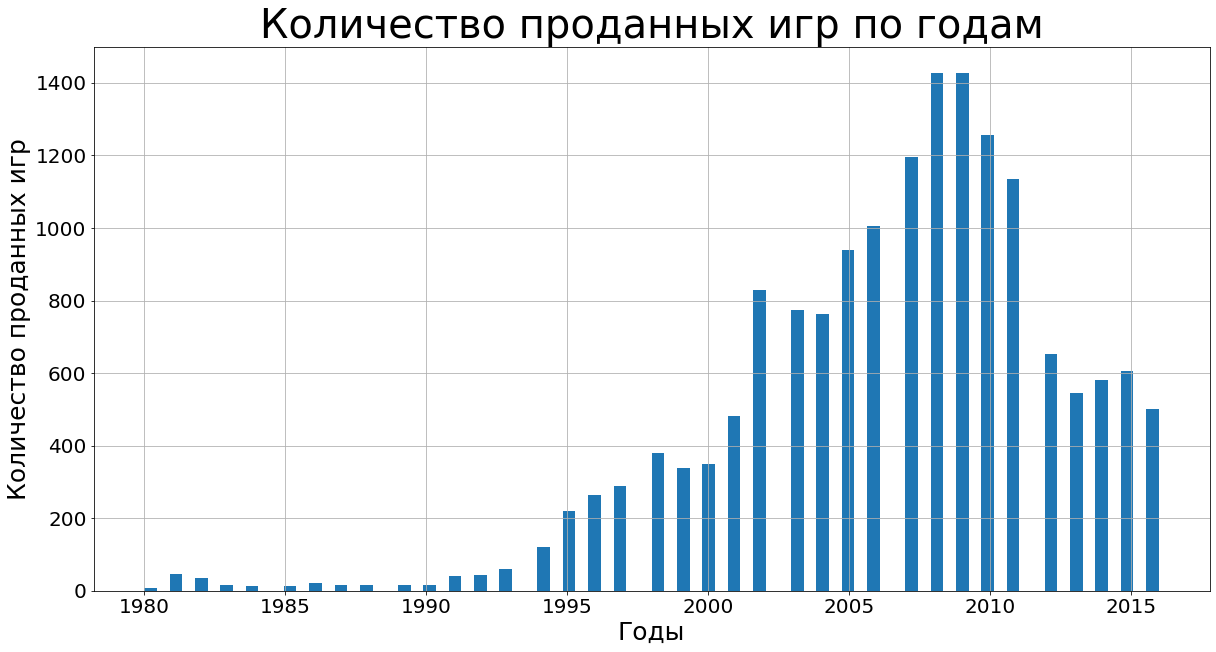

In [20]:
data['year_of_release'].hist(figsize=(20, 10), xlabelsize=20, ylabelsize=20, range=(1980, 2016), bins=80);
plt.title("Количество проданных игр по годам", fontsize=40)
plt.xlabel('Годы', fontsize=25);
plt.ylabel('Количество проданных игр', fontsize=25);

За 15 лет игр выпущено меньше, чем за самую маленькую первую пятилетку с 1995 года. Незнаю, все важны данные или нет на данном этапе. Ну смысла в первых 15 лет, действительно не вижу.

Сначала платформы с самыми высокими суммарными продажами.

In [21]:
data.groupby('platform')['all_sales'].sum().sort_values(ascending=False).head(10)

platform
PS2     1255.77
X360     971.42
PS3      939.65
Wii      907.51
DS       806.12
PS       730.86
GBA      317.85
PS4      314.14
PSP      294.05
PC       259.52
Name: all_sales, dtype: float64

Диаграмма распределения платформ по годам.

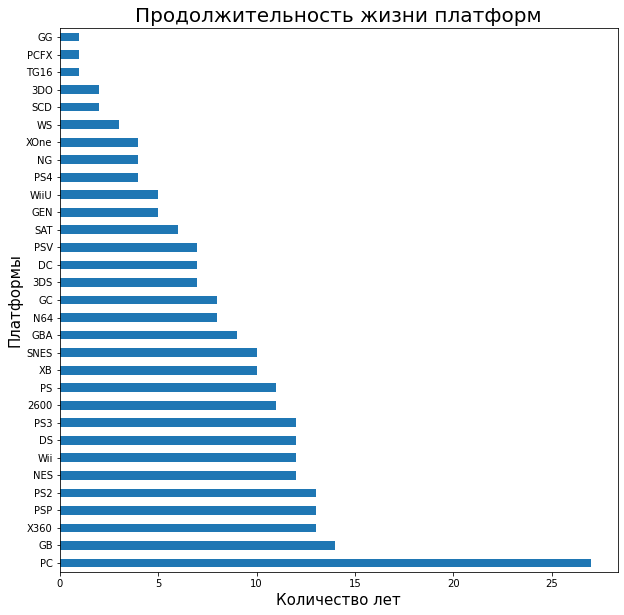

In [22]:
more_sales = data.pivot_table(index='year_of_release', columns='platform', values='all_sales', aggfunc='sum')
more_sales.count().sort_values(ascending=False).plot(kind="barh", figsize=(10, 10));
plt.title("Продолжительность жизни платформ", fontsize=20)
plt.xlabel('Количество лет', fontsize=15);
plt.ylabel('Платформы', fontsize=15);

Посмотрим в годах на лидеров, на их среднее и медиану.

In [23]:
print(more_sales.count().sort_values(ascending=False).head(10))
print(more_sales.count().sort_values(ascending=False).head(10).mean())
print(more_sales.count().sort_values(ascending=False).head(10).median())

platform
PC      27
GB      14
X360    13
PSP     13
PS2     13
NES     12
Wii     12
DS      12
PS3     12
2600    11
dtype: int64
13.9
12.5


Найдем вообще среднее и медиану по годам жизни приставки.

In [24]:
print(more_sales.count().sort_values(ascending=False).mean())
print(more_sales.count().sort_values(ascending=False).median())

8.193548387096774
8.0


Найдём усредненные показатели жизни приставки

In [25]:
(more_sales.count().sort_values(ascending=False).head(10).mean() + \
more_sales.count().sort_values(ascending=False).head(10).median() + \
more_sales.count().sort_values(ascending=False).mean() + \
more_sales.count().sort_values(ascending=False).median()) / 4


10.648387096774194

Будем считать, что 11 лет.

Таблица активности приставок по годам и суммы продаж.

In [26]:
data_times_platform = data.pivot_table(index='platform', columns='year_of_release', values='all_sales', aggfunc='sum')
data_times_platform

year_of_release,0,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
platform,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2600,10.50,11.38,35.68,28.88,5.84,0.27,0.45,0.67,1.94,0.74,0.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3DO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,0.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3DS,1.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.20,51.36,56.57,43.76,27.78,15.14
DC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.38,5.16,5.99,1.07,0.29,NaN,NaN,NaN,NaN,0.02,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DS,3.34,NaN,NaN,NaN,NaN,NaN,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.27,130.14,119.81,146.94,145.31,119.54,85.02,26.18,11.01,1.54,NaN,NaN,NaN
GB,1.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.43,64.97,4.89,5.57,25.49,NaN,12.18,3.60,36.03,6.37,26.90,38.00,19.76,9.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GBA,4.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.07,61.53,74.16,56.67,77.91,33.86,5.28,3.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GC,2.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.34,51.81,50.61,28.82,27.62,11.26,0.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GEN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.60,4.33,12.64,0.65,8.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Не так много приставок было активно в 2016 году. Посмотрим на (-1) средний срок жизни приставки.

In [27]:
data_life = data.query('year_of_release >= 2005')

In [28]:
data_life.pivot_table(index='platform', columns='year_of_release', values='all_sales', aggfunc='sum')

year_of_release,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
platform,,,,,,,,,,,,
3DS,NaN,NaN,NaN,NaN,NaN,NaN,63.20,51.36,56.57,43.76,27.78,15.14
DC,NaN,NaN,0.02,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DS,130.14,119.81,146.94,145.31,119.54,85.02,26.18,11.01,1.54,NaN,NaN,NaN
GBA,33.86,5.28,3.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GC,27.62,11.26,0.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PC,4.37,2.85,9.28,12.42,16.91,24.28,35.03,23.22,12.38,13.28,8.52,5.25
PS2,160.66,103.42,75.99,53.90,26.40,5.64,0.45,NaN,NaN,NaN,NaN,NaN
PS3,NaN,20.96,73.19,118.52,130.93,142.17,156.78,107.36,113.25,47.76,16.82,3.60
PS4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.99,100.00,118.90,69.25


Если смотреть на этот срок - видим, что можно отсечь ещё половину по годам. Есть приставки которые уже к середине нашей меры отжили или отживают свой срок. Что видно как по количеству лет, так и по прибыли.

In [29]:
data_life = data.query('year_of_release >= 2010')

In [30]:
data_life.pivot_table(index='platform', columns='year_of_release', values='all_sales', aggfunc='sum')

year_of_release,2010,2011,2012,2013,2014,2015,2016
platform,,,,,,,
3DS,NaN,63.20,51.36,56.57,43.76,27.78,15.14
DS,85.02,26.18,11.01,1.54,NaN,NaN,NaN
PC,24.28,35.03,23.22,12.38,13.28,8.52,5.25
PS2,5.64,0.45,NaN,NaN,NaN,NaN,NaN
PS3,142.17,156.78,107.36,113.25,47.76,16.82,3.60
PS4,NaN,NaN,NaN,25.99,100.00,118.90,69.25
PSP,35.04,17.82,7.69,3.14,0.24,0.12,NaN
PSV,NaN,4.63,16.19,10.59,11.90,6.25,4.25
Wii,127.95,59.65,21.71,8.59,3.75,1.14,0.18


Теперь возобновим информацию по самым продаваемым, по тем кто сейчас на рынке и разделим на группы. Вручную. Начнем с общих продаж, потом вернемся к последним продажам, кого не учли.

In [31]:
data_life.groupby('platform')['all_sales'].sum().sort_values(ascending=False) # те кто есть сейчас и сумма продаж

platform
PS3     587.74
X360    550.41
PS4     314.14
3DS     257.81
Wii     222.97
XOne    159.32
DS      123.75
PC      121.96
WiiU     82.19
PSP      64.05
PSV      53.81
PS2       6.09
Name: all_sales, dtype: float64

In [32]:
data.groupby('platform')['all_sales'].sum().sort_values(ascending=False).head(10) # самые больште продажи за все периоды.

platform
PS2     1255.77
X360     971.42
PS3      939.65
Wii      907.51
DS       806.12
PS       730.86
GBA      317.85
PS4      314.14
PSP      294.05
PC       259.52
Name: all_sales, dtype: float64

PS2 - самые больше продажи, но срок жизни истёк.

***X360*** - хорошие суммарные продажи, есть на рынке, но это закат. Если только самый крайний вариант.

***PS3*** - хорошие суммарные продажи, есть на рынке, но тоже закат. Ситуация чуть лучше чем у ***X360***, но не принципиально.
Wii - то же, что и у двух выше, но из-за последних продаж не стоит даже рассматривать.

DS - хорошие продажи, недавно были на рынке, но последние 3 года неактивны, прибыль последних лет, говорит что интерес растаял.
PS, GBA - не представлены на рынке

**PS4** - однозначно да. В середине своего пути, прибыль пока стабильно переваливает за 10 млн. И уже за 5 лет на рынке, вошла в топ самых продоваемых.

PSP - всего год нет на рынке, но последние продажи говорят, что это всё.

**PC** - в числе самых продаваемых, самый долгий, прибыль непостоянно но превышает млн. Тоже однозначно да.


******************************

**3DS** - не входит в самые продаваемые, но за последние 5 лет хорошо продаются, в середине своего пути, прибыль пока за 10 млн. Тоже да.

**XOne** - тоже да. Одни из самых больших продаж за последние пару лет, активны пока всего 4 года.

**WiiU** - тоже что и 3DS, тоже да, хотя прибыль меньше.

**PSV** - стоит рассмотреть, в следующем году ещё можно получить прибыль. Но суммарные продажи невысокие, и в середине пути где-то.

******************************

У нас есть группа победителей, и на ней стоит сосредоточиться - **PS4**, **PC**, **3DS**, **XOne**, **WiiU**, **PSV**. Характерно, что 4 из этих платформ это преемники более ранних версий, уже доживающих своё. На фоне денежной прибыли **PSV**, **3DS** можно рассмотреть ***X360***, ***PS3***.

Я решил оставить 6 приставок и работать с ними. Это то, куда стоит вкладывать деньги. Данными других приставок можно пренебречь, учитывая что дальше от нас просят **актуальный период**. Учитывать в актуальном периоде неактуальные приставки и портреты игроков - можно, но очень аккуратно, и в данной работе принебрегу, если не потребуется обратное.

In [33]:
data_period = (data
.query('''
(year_of_release >= 2010) & ((platform == "PS4") | (platform == "PC") | (platform == "3DS") | (platform == "XOne") | (platform == "WiiU") | (platform == "PSV"))
''')
)
data_period_pivot = data_period.pivot_table(index='platform', columns='year_of_release', values='all_sales', aggfunc='sum')
data_period_pivot

year_of_release,2010,2011,2012,2013,2014,2015,2016
platform,,,,,,,
3DS,NaN,63.20,51.36,56.57,43.76,27.78,15.14
PC,24.28,35.03,23.22,12.38,13.28,8.52,5.25
PS4,NaN,NaN,NaN,25.99,100.00,118.90,69.25
PSV,NaN,4.63,16.19,10.59,11.90,6.25,4.25
WiiU,NaN,NaN,17.56,21.65,22.03,16.35,4.60
XOne,NaN,NaN,NaN,18.96,54.07,60.14,26.15


Тут я воспользовался подсказкой на счёт актуального периода из Пачки. Взял 3 года, потому что за 2016 данные возможно неполные. За 2 года можно посмотреть динамику и не потеряться в прошлых данных(трендах). Если честно очень много потерял времент на этом. Я бы сам взял лет за 5, но аргументы про современные тренды - нахожу правильными.

In [34]:
data_period = data_period.query('year_of_release >= 2014')

Конкретно зачем строить здесь график распределения - я не понял, если честно. Но сделал. Небольшие выводы оформил.

Построю диаграмму распределения сначала отдельно для каждой платформы, чтобы оценить уровень и количество аномалий. Сохраню в отдельную переменную без выбросов.

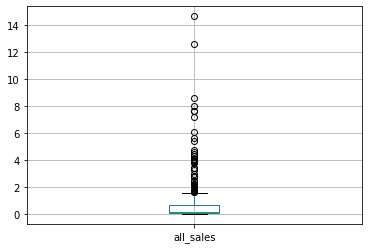

In [35]:
data_period[data_period['platform'] == "PS4"].boxplot(column='all_sales');

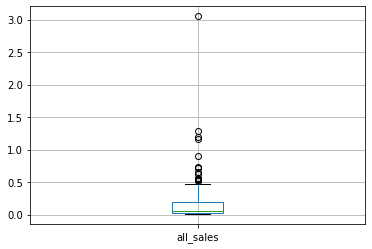

In [36]:
data_period[(data_period['platform'] == "PC")].boxplot(column='all_sales');

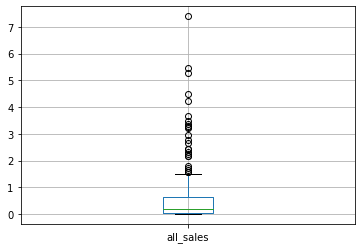

In [37]:
data_period[data_period['platform'] == "XOne"].boxplot(column='all_sales');

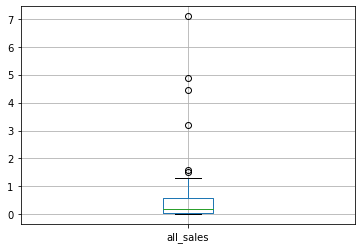

In [38]:
data_period[data_period['platform'] == "WiiU"].boxplot(column='all_sales');

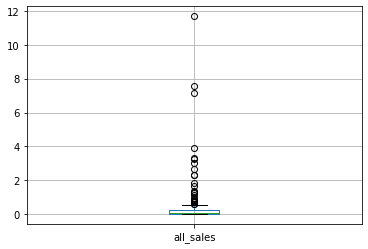

In [39]:
data_period[data_period['platform'] == "3DS"].boxplot(column='all_sales');

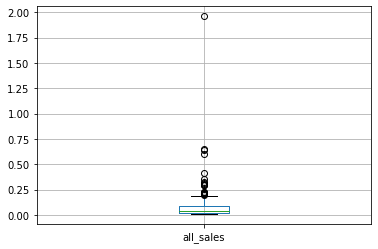

In [40]:
data_period[data_period['platform'] == "PSV"].boxplot(column='all_sales');

Дальше отсеку аномалии и построю общий график.

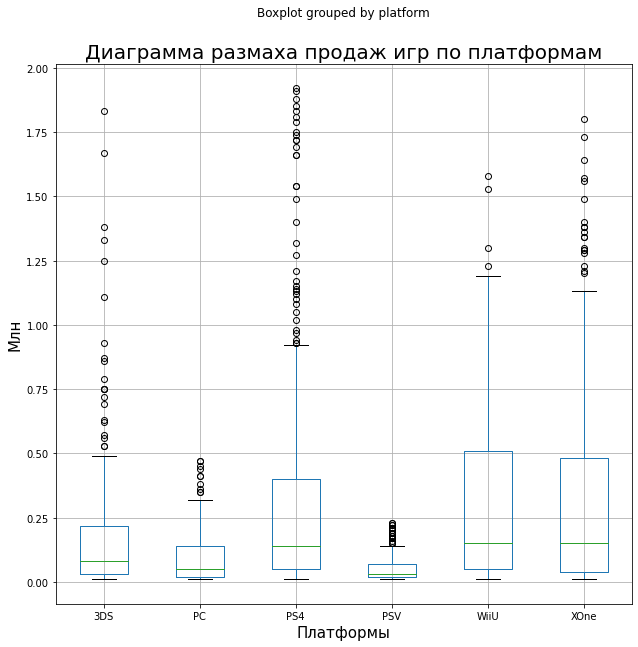

In [41]:
data_boxplot = (
data_period[((data_period['platform'] == "PS4") & (data_period['all_sales'] <= 2)) |
           ((data_period['platform'] == "PC") & (data_period['all_sales'] <= 0.5)) |
           ((data_period['platform'] == "XOne") & (data_period['all_sales'] <= 2)) |
           ((data_period['platform'] == "WiiU") & (data_period['all_sales'] <= 2)) |
           ((data_period['platform'] == "3DS") & (data_period['all_sales'] <= 2)) |
           ((data_period['platform'] == "PSV") & (data_period['all_sales'] <= 0.25))]
)
data_boxplot.boxplot(column='all_sales', by='platform', figsize=(10, 10));
plt.title("Диаграмма размаха продаж игр по платформам", fontsize=20);
plt.xlabel('Платформы', fontsize=15);
plt.ylabel('Млн', fontsize=15);

По сравнению с выбросами, которые есть, медиана везде находится около 0. Верхний ус на 3 из 6 платформ находится около 1 млн, на 3 других меньше млн. Есть уникальные продажи на > 10 млн, и рекордные продажи на каждой платформе.

Самые большие продажи можно ожидать на WiiU, почти столько же на XOne, PS4 так же можно отнести к ним в группу - у них примерно одинаковые медианы на уровне 125.тыс. Самая маленькая медиана продаж у PSV и граница коробки даже не дотягивает до медиан ведущих платформ. 3DS и PC - во второй группу, стоит ожидать от игр продаж меньше 250 тыс, против 500 тыс. в первой. 

Есть уникальные продажи на > 10 млн, и рекордные продажи на каждой платформе.

Далее работаем с зависимостью оценками критиков и пользователей на продажи.

Проанализируем как влияют на продажи внутри одной из популярных платформ отзывы критикови и пользователей.

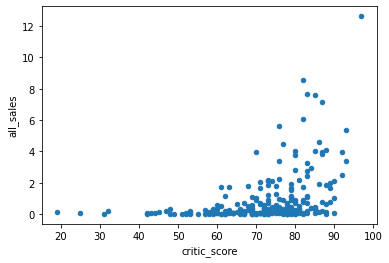

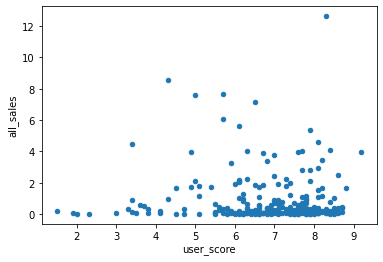

In [42]:
data_period[data_period['platform'] == 'PS4'].plot(x='critic_score', y='all_sales', kind='scatter');
data_period[data_period['platform'] == 'PS4'].plot(x='user_score', y='all_sales', kind='scatter');

In [43]:
(print('Рейтинг критиков:', 
data_period[data_period['platform'] == 'PS4']['critic_score'].corr(data_period['all_sales']))
)
(print('Рейтинг пользователей:',
       data_period[data_period['platform'] == 'PS4']['user_score'].corr(data_period['all_sales']))
)

Рейтинг критиков: 0.40266141068104083
Рейтинг пользователей: -0.040131589472697356


График показывает, что у плохих игр по мнению критиков, нет хороших продаж. Тут интересно сравнить с мнением пользователей, что у плохих и средних игр есть хорошие продажи, более того - самые высокие продажи находятся в диапозоне средних и даже ниже.

Если смотреть на цифры - между мнением критиков и продажами, корреляция слабовыраженная. Между мнением пользователей и продажами зависимости нет.

На графиках видна ещё пропасть - и пользователи, и критики доходят до оценки 9 и 90, и провал. У пользователей вообще сложно заслужить такую оценку и выше.

Есть единичные уникумы, которые и хорошо продаются, и очень высокие мнения пользователей и критиков.

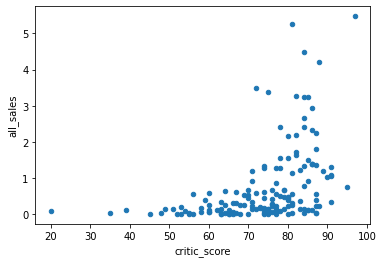

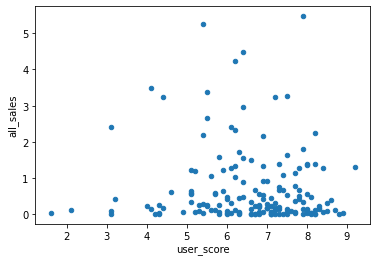

In [44]:
data_period[data_period['platform'] == 'XOne'].plot(x='critic_score', y='all_sales', kind='scatter');
data_period[data_period['platform'] == 'XOne'].plot(x='user_score', y='all_sales', kind='scatter');

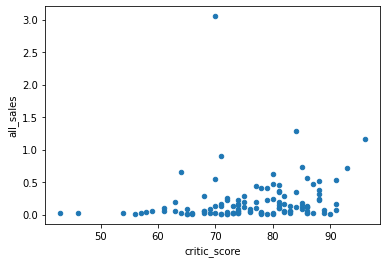

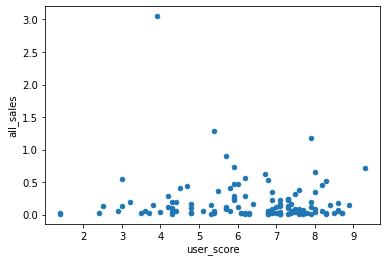

In [45]:
data_period[data_period['platform'] == 'PC'].plot(x='critic_score', y='all_sales', kind='scatter');
data_period[data_period['platform'] == 'PC'].plot(x='user_score', y='all_sales', kind='scatter');

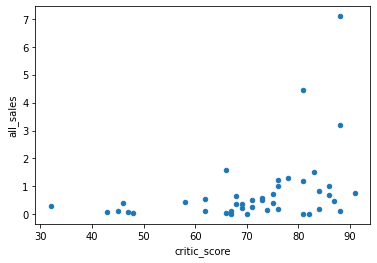

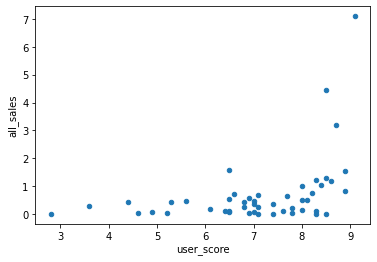

In [46]:
data_period[data_period['platform'] == 'WiiU'].plot(x='critic_score', y='all_sales', kind='scatter');
data_period[data_period['platform'] == 'WiiU'].plot(x='user_score', y='all_sales', kind='scatter');

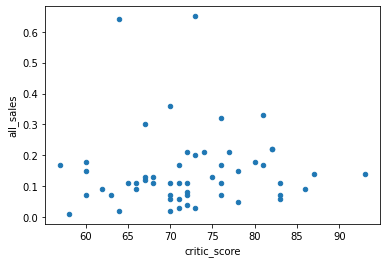

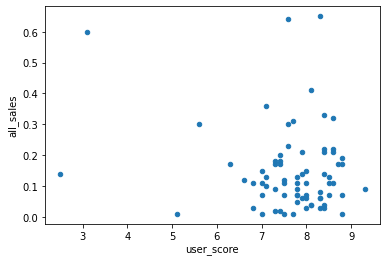

In [47]:
data_period[data_period['platform'] == 'PSV'].plot(x='critic_score', y='all_sales', kind='scatter');
data_period[data_period['platform'] == 'PSV'].plot(x='user_score', y='all_sales', kind='scatter');

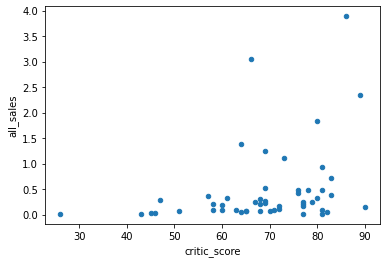

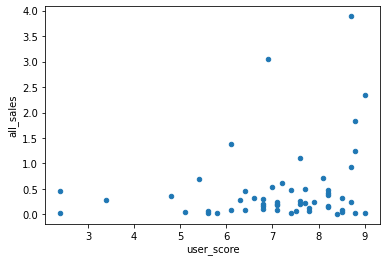

In [48]:
data_period[data_period['platform'] == '3DS'].plot(x='critic_score', y='all_sales', kind='scatter');
data_period[data_period['platform'] == '3DS'].plot(x='user_score', y='all_sales', kind='scatter');

У XOne графики очень похожи на PS4. Дальше видно, что игр меньше. Графики, примерно, стремятся к PS4. Есть свои особенности - предвзятые очень пользователи и чуть менее предвзятые критики у PSV; одна запредельная продажа на PC и в целом равномерно как-то распределены продажи.

Коррелляция

In [49]:
(print('Рейтинг критиков XOne:', 
data_period[data_period['platform'] == 'XOne']['critic_score'].corr(data_period['all_sales']))
)
(print('Рейтинг пользователей XOne:',
       data_period[data_period['platform'] == 'XOne']['user_score'].corr(data_period['all_sales']))
)

(print('Рейтинг критиков PC:', 
data_period[data_period['platform'] == 'PC']['critic_score'].corr(data_period['all_sales']))
)
(print('Рейтинг пользователей PC:',
       data_period[data_period['platform'] == 'PC']['user_score'].corr(data_period['all_sales']))
)

(print('Рейтинг критиков PSV:', 
data_period[data_period['platform'] == 'PSV']['critic_score'].corr(data_period['all_sales']))
)
(print('Рейтинг пользователей PPSV:',
       data_period[data_period['platform'] == 'PSV']['user_score'].corr(data_period['all_sales']))
)

(print('Рейтинг критиков 3DS:', 
data_period[data_period['platform'] == '3DS']['critic_score'].corr(data_period['all_sales']))
)
(print('Рейтинг пользователей 3DS:',
       data_period[data_period['platform'] == '3DS']['user_score'].corr(data_period['all_sales']))
)

(print('Рейтинг критиков WiiU:', 
data_period[data_period['platform'] == 'WiiU']['critic_score'].corr(data_period['all_sales']))
)
(print('Рейтинг пользователей WiiU:',
       data_period[data_period['platform'] == 'WiiU']['user_score'].corr(data_period['all_sales']))
)

Рейтинг критиков XOne: 0.42867694370333226
Рейтинг пользователей XOne: -0.0703839280647581
Рейтинг критиков PC: 0.17463413769350036
Рейтинг пользователей PC: -0.07159665703472451
Рейтинг критиков PSV: 0.04266490657009526
Рейтинг пользователей PPSV: -0.16845504978064446
Рейтинг критиков 3DS: 0.314117492869051
Рейтинг пользователей 3DS: 0.2151932718527028
Рейтинг критиков WiiU: 0.370201412480884
Рейтинг пользователей WiiU: 0.40792645792170773


В целом схожая картина с исключениями - на PC между критиками и продажами корреляции нет, самая низкая. У пользователей WiiU есть слабо выраженная корреляция с продажами.

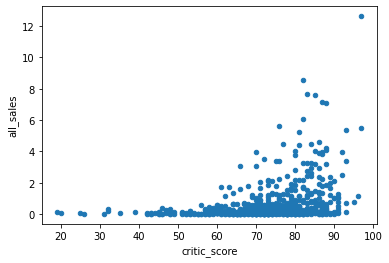

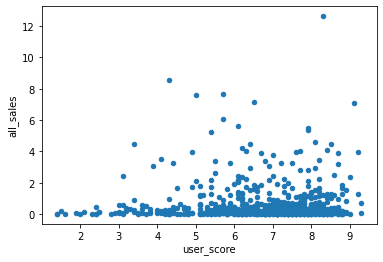

In [50]:
data_period.plot(x='critic_score', y='all_sales', kind='scatter');
data_period.plot(x='user_score', y='all_sales', kind='scatter');

In [51]:
data_period['critic_score'].corr(data_period['all_sales'])

0.3272705661300674

In [52]:
data_period['user_score'].corr(data_period['all_sales'])

-0.003197872211426589

Какой-либо зависимости я не увидел. По цифрам корреляции нет. Что у пользователей игры с оценками ~3 и у критиков 60 балов - нет хороших продаж. Они растут после данных чисел. И после 6 и 70 начинаются какие-то закономерности положительные в деньгах.
По цифрам показывает, что корреляции нет. С оценками критиков, вообще им как-будто лучше не оценивать хорошие игры.

Общая картина по всем платформам стремится к PS4 и XOne.

Исследование жанров.

In [53]:
data_period['genre'].value_counts()

Action          495
Role-Playing    187
Adventure       148
Sports          104
Shooter          99
Misc             89
Racing           53
Simulation       40
Fighting         38
Strategy         36
Platform         33
Puzzle           13
Name: genre, dtype: int64

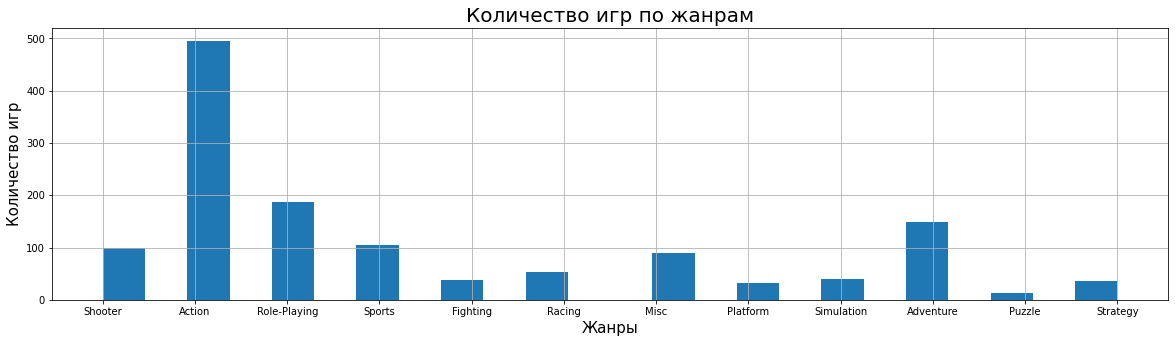

In [54]:
data_period['genre'].hist(figsize=(20, 5), bins=24);
plt.title("Количество игр по жанрам", fontsize=20)
plt.xlabel('Жанры', fontsize=15);
plt.ylabel('Количество игр', fontsize=15);

In [55]:
data_period.groupby('genre')['all_sales'].sum().sort_values(ascending=False)

genre
Action          167.54
Shooter         145.11
Role-Playing     92.05
Sports           77.96
Misc             26.43
Racing           24.88
Fighting         24.67
Platform         17.14
Adventure        13.44
Simulation       12.33
Strategy          3.90
Puzzle            2.17
Name: all_sales, dtype: float64

Учиитывая количество игровых платформ в списке - ничего удивительного, что лидирует жанр Action. С 3 кратным отрывом. 2 группа вместе догоняет лидера Role-Playing , Adventure, Sports, Shooter, Misc. Их количество продаж держится на трёх-значном числе. А вот гоночки, пазлы, драки и симуляторы - продаются совсем плохо.

Если же брать в денежном эквиваленте - лидер всё тотже Action, но отрыва у него практически нет никакого. Причём один лидеров по количеству продаж по количеству денег в аутсайдерах - Adventure. B лидерах остались Shooter, Sports, Role-Playing. У Shooter чуть меньше, чем у жанра Action, и разници между ним и Role-Playing-последним среди лидеров - 70 млн. Такая же разница между Role-Playing и между первым в списке - остальных.

In [56]:
(data_period
.pivot_table(index='genre', values='all_sales', aggfunc=['count', 'sum', 'max', 'min', 'mean', 'median'])
.sort_values(by=('median', 'all_sales'), ascending=False)
)

,count,sum,max,min,mean,median
,all_sales,all_sales,all_sales,all_sales,all_sales,all_sales
genre,,,,,,
Shooter,99,145.11,14.63,0.01,1.465758,0.550
Sports,104,77.96,8.58,0.01,0.749615,0.200
Platform,33,17.14,3.21,0.01,0.519394,0.150
Fighting,38,24.67,7.55,0.02,0.649211,0.125
Role-Playing,187,92.05,11.68,0.01,0.492246,0.110
Simulation,40,12.33,3.05,0.01,0.308250,0.100
Misc,89,26.43,4.32,0.01,0.296966,0.090
Racing,53,24.88,7.09,0.01,0.469434,0.090


1. Shooter - самый прибыльный. Самая высокая медиана, среднее, максимальная продажа и 2 место по сумме продаж + конкуренция не самая высокая.
2. Sports - вторая медиана и среднее в списке. Максимальная продажа и сумма продаж уже 4 в списке, опять же не самая высокая конкуренция.
3. Platform, fighting - очень хорошие средние и медиана, но ближе к концу списка сумма продаж и максимальная продажа. Конкуренция одна из самых маленьких на рынке.
4. Role-Playing - 3 место по прибыли и сумме продаж, но среднее и медиана ближе к середине, из-за высокой конкуренции. Одной из самых высоких на рынке.
5. Action - в него много играют, болшая конкуренция, самая высокая суммарная прибыль, 2 место по максимальной продаже, но среднее и медиана очень маленькие.
6. Simulation, misc, racing - что-то вроде середины. Есть относительно хорошие показатели.

### Вывод

Средняя продолжительность жизни платформы - 11 лет.

Список актуальных игровых платформ - PS4, PC, 3DS, XOne, WiiU, PSV. Характерно, что 4 из этих платформ это преемники более ранних версий, уже доживающих своё. На фоне денежной прибыли PSV, 3DS можно рассмотреть X360, PS3.

Актуальный период был выбран - 3 года. Захватить современные тенденции и он органично получался от срока жизни приставок.

Самые большие продажи можно ожидать на WiiU, почти столько же на XOne, PS4 так же можно отнести к ним в группу - у них примерно одинаковые медианы на уровне 125.тыс. Самая маленькая медиана продаж у PSV и граница коробки даже не дотягивает до медиан ведущих платформ. 3DS и PC - во второй группу, стоит ожидать от игр продаж меньше 250 тыс, против 500 тыс. в первой.

Есть уникальные продажи на > 10 млн, и рекордные продажи на каждой платформе.

Графики зависимостей между мнением пользователей, мнением критиков и продажами на PS4, показывают, что у плохих игр по мнению критиков, нет хороших продаж. По мнению пользователей у плохих и средних игр есть хорошие продажи, более того - самые высокие продажи находятся в диапозоне средних и даже ниже.

Если смотреть на цифры - между мнением критиков и продажами, корреляция слабовыраженная. Между мнением пользователей и продажами зависимости нет.

На графиках видна ещё пропасть - и пользователи, и критики доходят до оценки 9 и 90, и провал. У пользователей вообще сложно заслужить такую оценку и выше.

Есть единичные уникумы, которые и хорошо продаются, и очень высокие мнения пользователей и критиков.

В целом и отдельно по другим платформам картина похожа, с некоторыми своими особенностями у некоторых платформ. XOne прям очень похожа.

По жанрам:

1. Shooter - самый прибыльный. Самая высокая медиана, среднее, максимальная продажа и 2 место по сумме продаж + конкуренция не самая высокая.
2. Sports - вторая медиана и среднее в списке. Максимальная продажа и сумма продаж уже 4 в списке, опять же не самая высокая конкуренция.
3. Platform, fighting - очень хорошие средние и медиана, но ближе к концу списка сумма продаж и максимальная продажа. Конкуренция одна из самых маленьких на рынке.
4. Role-Playing - 3 место по прибыли и сумме продаж, но среднее и медиана ближе к середине, из-за высокой конкуренции. Одной из самых высоких на рынке.
5. Action - в него много играют, болшая конкуренция, самая высокая суммарная прибыль, 2 место по максимальной продаже, но среднее и медиана очень маленькие.
6. Simulation, misc, racing - что-то вроде середины. Есть относительно хорошие показатели.


## Портрет пользователя каждого региона

In [57]:
data_period.groupby('platform')['na_sales'].sum().sort_values(ascending=False).head(5)

platform
PS4     98.61
XOne    81.27
3DS     22.64
WiiU    19.36
PC       7.23
Name: na_sales, dtype: float64

In [58]:
data_period.groupby('platform')['eu_sales'].sum().sort_values(ascending=False).head(5)

platform
PS4     130.04
XOne     46.25
PC       17.97
3DS      16.12
WiiU     13.15
Name: eu_sales, dtype: float64

In [59]:
data_period.groupby('platform')['jp_sales'].sum().sort_values(ascending=False).head(5)

platform
3DS     44.24
PS4     15.02
PSV     14.54
WiiU     7.31
XOne     0.32
Name: jp_sales, dtype: float64

В Северной Америке(СА) прибыль более равномерно распределена между лидерами, последним поколением консолей. В Европе перекос в сторону PS4 . Списки лидеров примерно одинаковы, но в Европе X360 уступиал место PC. В СА больше уважают приставки, ну что видно по распределнию почти равных продаж и отсутствию компьютера в лидерах. В Европе по какой-то причине предпочитают PS4 почти в 4 раза и больше всему остальному.

Японские игроки стоят отдельно. Скромные продажи на фоне остального мира. Вообще нет X-приставок. Все PS есть активные. В лидерах есть приставки, которые не котируюся в СА и Европе. 

In [60]:
data_period.groupby('genre')['na_sales'].sum().sort_values(ascending=False).head(5)

genre
Shooter         66.29
Action          60.16
Sports          31.96
Role-Playing    29.74
Fighting        11.23
Name: na_sales, dtype: float64

In [61]:
data_period.groupby('genre')['eu_sales'].sum().sort_values(ascending=False).head(5)

genre
Action          63.49
Shooter         56.23
Sports          33.48
Role-Playing    25.94
Racing          12.92
Name: eu_sales, dtype: float64

In [62]:
data_period.groupby('genre')['jp_sales'].sum().sort_values(ascending=False).head(5)

genre
Role-Playing    28.70
Action          24.71
Misc             5.17
Fighting         5.01
Shooter          4.21
Name: jp_sales, dtype: float64

По жанрам игроки СА и Европы - очень сильно похожи. Прям практически идентичны даже по цифрам. За исключением, что на 5 месте в Европе гонки, в СА "остальные".

Япония опять отдельно - Role-Playin и Action в лидерах так-же, только занимают 1 и 2 места, продажи опять скромные на фоне другого мира. Жанр Shooter лидер в остальных регионах практически не играется. По продажам можно сказать, что там ни во что больше не играют кроме ролевых и экшен. Между вторым и третьим - разница в пять раз.

In [63]:
data_period.groupby('rating')['na_sales'].sum().sort_values(ascending=False)

rating
M       82.23
E       37.65
T       32.46
E10+    23.53
Name: na_sales, dtype: float64

In [64]:
data_period.groupby('rating')['eu_sales'].sum().sort_values(ascending=False)

rating
M       82.38
E       45.90
T       30.09
E10+    17.89
Name: eu_sales, dtype: float64

In [65]:
data_period.groupby('rating')['jp_sales'].sum().sort_values(ascending=False)

rating
T       11.99
E        8.29
M        6.40
E10+     4.32
Name: jp_sales, dtype: float64

Не увидел никакой зависимости. Может быть задание не понял. Не вижу никакой зависимости между рейтингом и продажами. Они даже в цифрах одинаковые по регионам. И Япония особняком , как понимаю T - подростки, они играют больше всех там, в отличие от 17+ в других регионах.

### Вывод 

В Северной Америке(СА) прибыль более равномерно распределена между лидерами, последним поколением консолей. В Европе перекос в сторону PS4 . Списки лидеров примерно одинаковы, но в Европе X360 уступиал место PC. В СА больше уважают приставки, ну что видно по распределнию почти равных продаж и отсутствию компьютера в лидерах. В Европе по какой-то причине предпочитают PS4 почти в 4 раза и больше всему остальному.

Японские игроки стоят отдельно. Скромные продажи на фоне остального мира. Вообще нет X-приставок. Все PS есть активные. В лидерах есть приставки, которые не котируюся в СА и Европе. 


По жанрам игроки СА и Европы - очень сильно похожи. Прям практически идентичны даже по цифрам. За исключением, что на 5 месте в Европе гонки, в СА "остальные".

Япония опять отдельно - Role-Playin и Action в лидерах так-же, только занимают 1 и 2 места, продажи опять скромные на фоне другого мира. Жанр Shooter лидер в остальных регионах практически не играется. По продажам можно сказать, что там ни во что больше не играют кроме ролевых и экшен. Между вторым и третьим - разница в пять раз.


### Проверка гипотез 

Средние пользовательские рейтинги платформ Xbox One и PC одинаковые - H0
Средние пользовательские рейтинги платформ Xbox One и PC разные - H1

Будем использовать метод из тренажёров для сравнения двух не парных выборок. Дисперсию поставим разную, так как наврядли будет одинаковая - как понимаю из-за разного размера из-за пропуска.

Нам не важно в какую сторону отклоняется значение, больше или меньше. Гипотеза двусторонняя. 

In [66]:
data_xbox = data_period.query('platform == "XOne"')
data_pc = data_period.query('platform == "PC"')

In [67]:
results = st.ttest_ind(data_xbox['user_score'].dropna(), data_pc['user_score'].dropna(), equal_var=False)

alpha = 0.05

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.11601398086668832
Не получилось отвергнуть нулевую гипотезу


Будем также использовать метод из тренажёров , но немного другой:
     Метод scipy.stats.ttest_1samp() возвращает два числа: статистику разности и уровень значимости для этой статистики — p-value
     
Меня интересует значение среднего, передаю его вторым аргументом, и если уж разное прям нужно, и правильно понимаю, пусть p-value будет минимальным.

Средние пользовательские рейтинги жанров Action и Sports равны - H0

Средние пользовательские рейтинги жанров Action и Sports разные - H1

In [68]:
interested_value = data_period.query('genre == "Action"')['user_score'].dropna().mean()

alpha = 0.05

results_2 = st.ttest_1samp(data_period.query('genre == "Sports"')['user_score'].dropna(), interested_value)

print('p-значение:', results_2.pvalue)

if results_2.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 1.3473891377643894e-09
Отвергаем нулевую гипотезу


Получается, что средние пользовательские рейтинги жанров Action и Sports разные

## Общий вывод

### Предосмотр данных.

Заглавные буквы в названии столбцов.

8 из 11 столбцов значимого количества пропусков не имеют. В 3 последних пропуски есть и это до половины данных.

У некоторых столбцов неправильные типы данных.

Предварительно гистограммы показывают наличие выбросов и аномалий. Разнообразие в категориальных данных. Некоторые данные не отобразились или некорректно. Одна из причин это неправильные типы данных.

Явных дубликатов нет.


### Предобработка данных.

Кроме 2 строк в с пропусками в названии и жанре - все остальные пропуски человеческий фактор, старые сведения, бд. Эти 2 пропуска - 50 на 50, возможно, технический фактор.

Два столбца имели неправильный тип данных - один по техническим причинам, второй из-за наличия категориальной переменной, которая по прошествию времени смысла не имела и портила смысл количественной переменной.

Были удалены пропуски в названиях и жанре - 2 шт. Остальные остались без изменений.

Явных и неявных дубликатов нет.

Был создан новый столбец со всеми продажами по данной игре.


### Исследовательский анализ данных
Средняя продолжительность жизни платформы - 11 лет.

Список актуальных игровых платформ - PS4, PC, 3DS, XOne, WiiU, PSV. Характерно, что 4 из этих платформ это преемники более ранних версий, уже доживающих своё. На фоне денежной прибыли PSV, 3DS можно рассмотреть X360, PS3.

Актуальный период был выбран - 3 года. Захватить современные тенденции и он органично получался от срока жизни приставок.

Самые большие продажи можно ожидать на WiiU, почти столько же на XOne, PS4 так же можно отнести к ним в группу - у них примерно одинаковые медианы на уровне 125.тыс. Самая маленькая медиана продаж у PSV и граница коробки даже не дотягивает до медиан ведущих платформ. 3DS и PC - во второй группу, стоит ожидать от игр продаж меньше 250 тыс, против 500 тыс. в первой.

Есть уникальные продажи на > 10 млн, и рекордные продажи на каждой платформе.

Графики зависимостей между мнением пользователей, мнением критиков и продажами на PS4, показывают, что у плохих игр по мнению критиков, нет хороших продаж. По мнению пользователей у плохих и средних игр есть хорошие продажи, более того - самые высокие продажи находятся в диапозоне средних и даже ниже.

Если смотреть на цифры - между мнением критиков и продажами, корреляция слабовыраженная. Между мнением пользователей и продажами зависимости нет.

На графиках видна ещё пропасть - и пользователи, и критики доходят до оценки 9 и 90, и провал. У пользователей вообще сложно заслужить такую оценку и выше.

Есть единичные уникумы, которые и хорошо продаются, и очень высокие мнения пользователей и критиков.

В целом и отдельно по другим платформам картина похожа, с некоторыми своими особенностями у некоторых платформ. XOne прям очень похожа.

По жанрам:

1. Shooter - самый прибыльный. Самая высокая медиана, среднее, максимальная продажа и 2 место по сумме продаж + конкуренция не самая высокая.
2. Sports - вторая медиана и среднее в списке. Максимальная продажа и сумма продаж уже 4 в списке, опять же не самая высокая конкуренция.
3. Platform, fighting - очень хорошие средние и медиана, но ближе к концу списка сумма продаж и максимальная продажа. Конкуренция одна из самых маленьких на рынке.
4. Role-Playing - 3 место по прибыли и сумме продаж, но среднее и медиана ближе к середине, из-за высокой конкуренции. Одной из самых высоких на рынке.
5. Action - в него много играют, болшая конкуренция, самая высокая суммарная прибыль, 2 место по максимальной продаже, но среднее и медиана очень маленькие.
6. Simulation, misc, racing - что-то вроде середины. Есть относительно хорошие показатели.



### Портрет пользователя.

В Северной Америке(СА) прибыль более равномерно распределена между лидерами, последним поколением консолей. В Европе перекос в сторону PS4 . Списки лидеров примерно одинаковы, но в Европе X360 уступиал место PC. В СА больше уважают приставки, ну что видно по распределнию почти равных продаж и отсутствию компьютера в лидерах. В Европе по какой-то причине предпочитают PS4 почти в 4 раза и больше всему остальному.

Японские игроки стоят отдельно. Скромные продажи на фоне остального мира. Вообще нет X-приставок. Все PS есть активные. В лидерах есть приставки, которые не котируюся в СА и Европе.

По жанрам игроки СА и Европы - очень сильно похожи. Прям практически идентичны даже по цифрам. За исключением, что на 5 месте в Европе гонки, в СА "остальные".

Япония опять отдельно - Role-Playin и Action в лидерах так-же, только занимают 1 и 2 места, продажи опять скромные на фоне другого мира. Жанр Shooter лидер в остальных регионах практически не играется. По продажам можно сказать, что там ни во что больше не играют кроме ролевых и экшен. Между вторым и третьим - разница в пять раз.

### Проверка гипотез

Средние пользовательские рейтинги платформ Xbox One и PC одинаковые - нулевая

Средние пользовательские рейтинги жанров Action и Sports разные - альтернативная